# [Real or Fake] : Fake Job Description Prediction
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRCSJEp0uveDRpbG9W1oGoPVsDHGC2b2Z-qnyFrAn8wcwqJmf9w" align="left" height="200" width="200">
This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

In [1]:
"""Importing libraries"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score

from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
df = pd.read_csv("../input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
"""Missing values"""
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [4]:
"""Extracting Text Featurs"""

text_df = df[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [5]:
"""Catagorical Feature"""
cat_df = df[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function","fraudulent"]]
cat_df = cat_df.fillna("None")

cat_df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Target

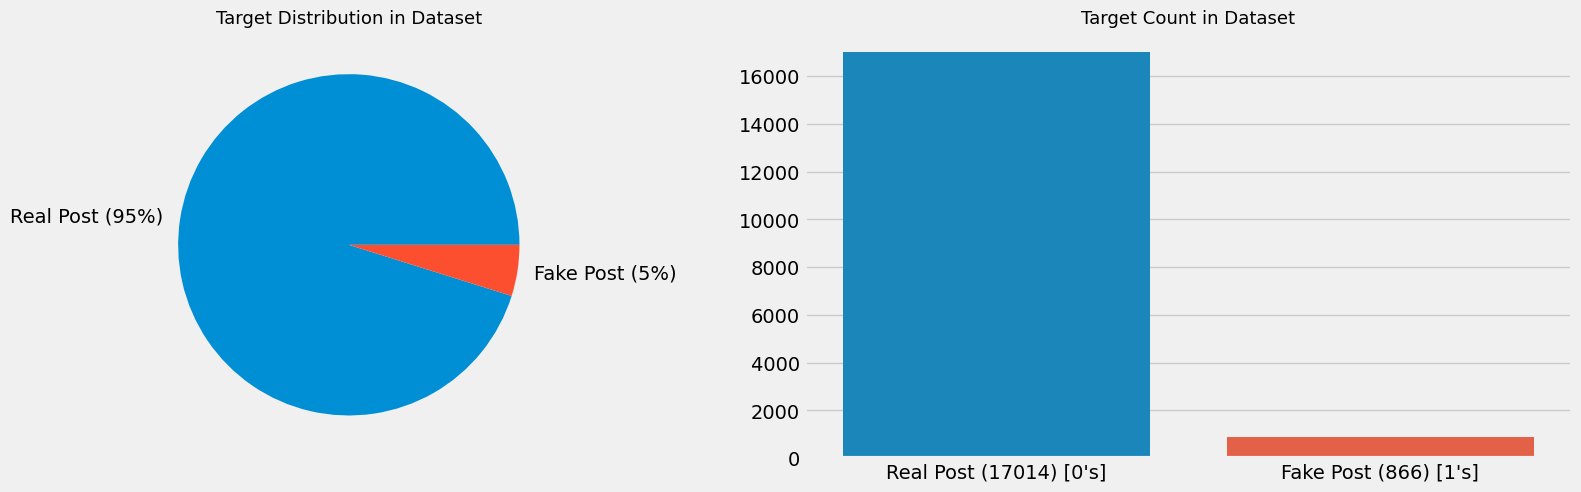

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fake Post (5%)'])
temp = df["fraudulent"].value_counts()
sns.barplot(temp.index, temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fake Post (866) [1's]"])

axes[0].set_title('Target Distribution in Dataset', fontsize=13)
axes[1].set_title('Target Count in Dataset', fontsize=13)

plt.show()

Hmm!! Class distributions are **95% for 0 (Real Post)** and **5% for 1 (Fake Post).** Target distribution is highly imbalanced. Accuracy metric is not useful here it will mislead the result. So, we've to look into Precision, Recall, F1 Score for model evalution.

# Exploratory Data Analysis of tweets

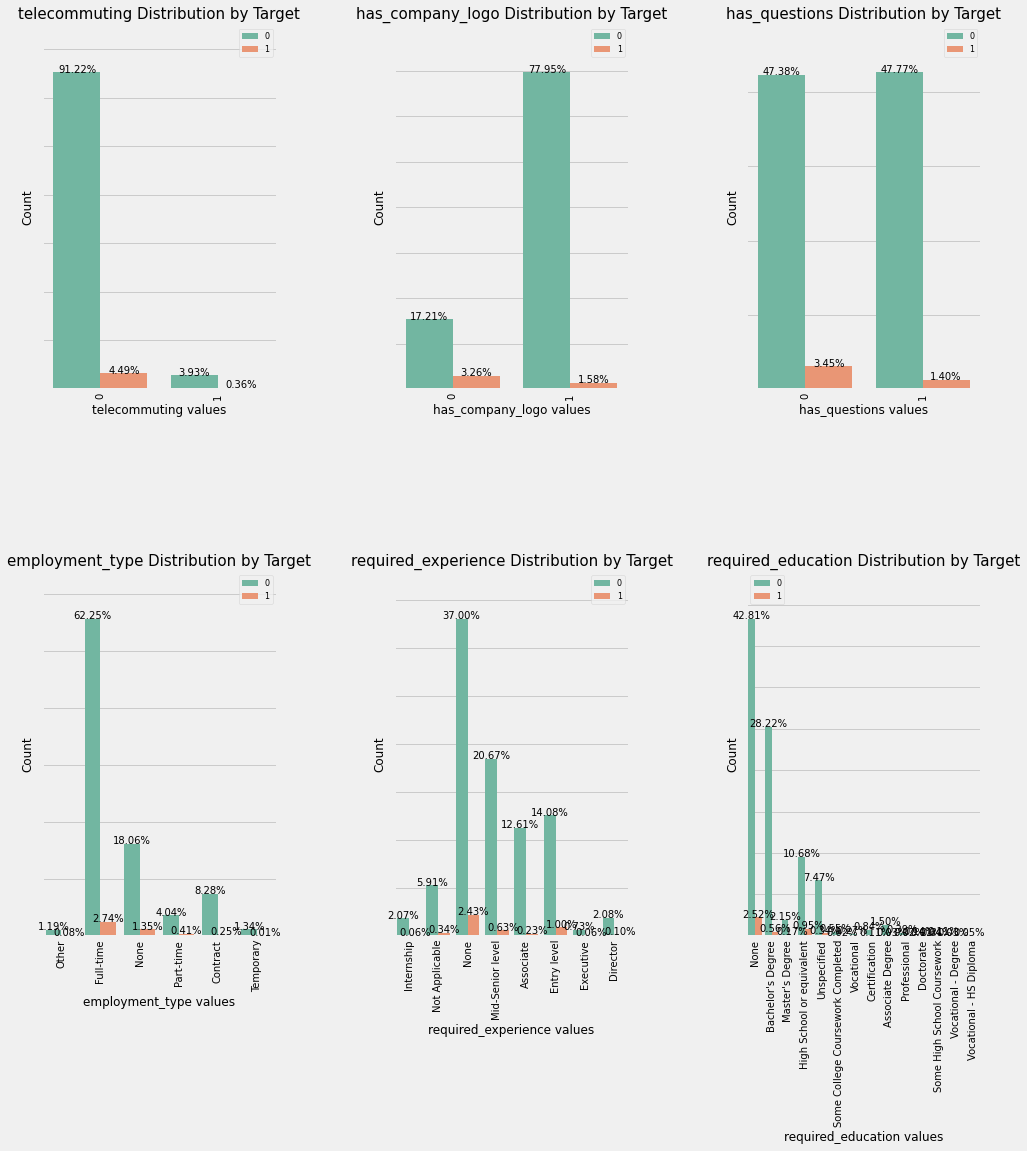

In [7]:
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education",]
# visualizating catagorical variable by target
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5) # The grid of chart
plt.figure(figsize=(15,25)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(cat_df[cat_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=cat_df, hue='fraudulent', palette='Set2') 
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=15) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels() 
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(fontsize=8)
    plt.xticks(rotation=90) 
    total = len(cat_df)
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights


plt.show()


## Number of characters
Let's compare the number of character in the fake post and real post and try to distinguish pattern in the fake and real post based on number of charater used in the post.

#### Company profile
We can see that **fake post has less characters** in the company profile while **real post has more charaters.**

#### Description

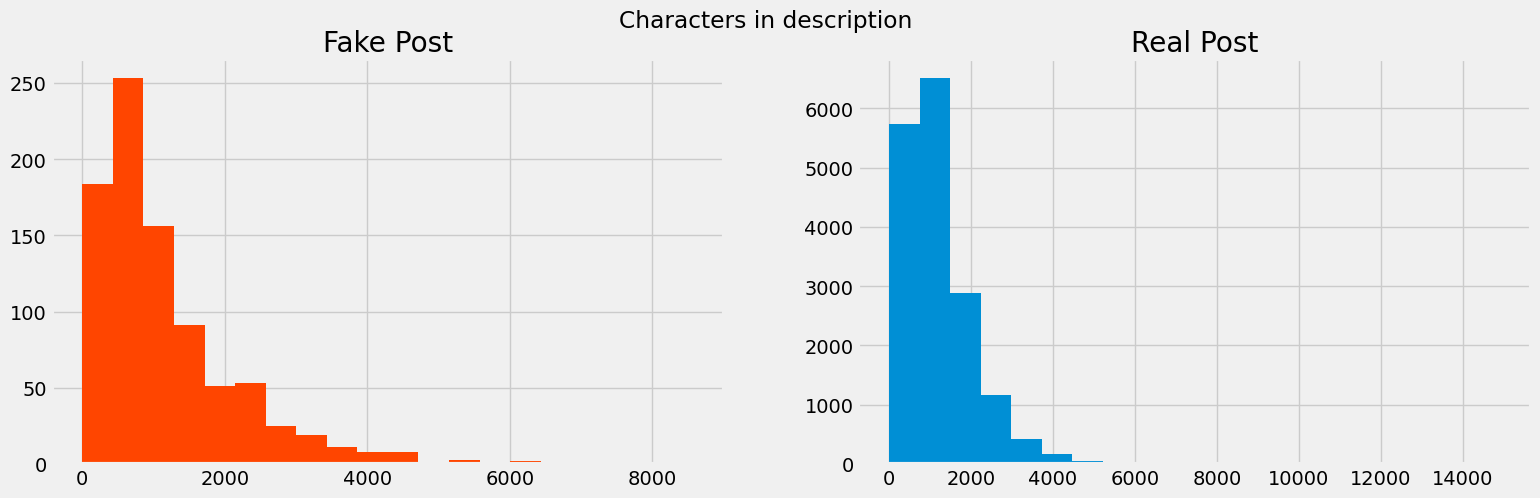

In [8]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['description'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['description'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in description')
plt.show()

The distribution of charaters in description of the fake and real post are similar but some fake post reach to 6000 to 6500 characters. 

#### Requirements

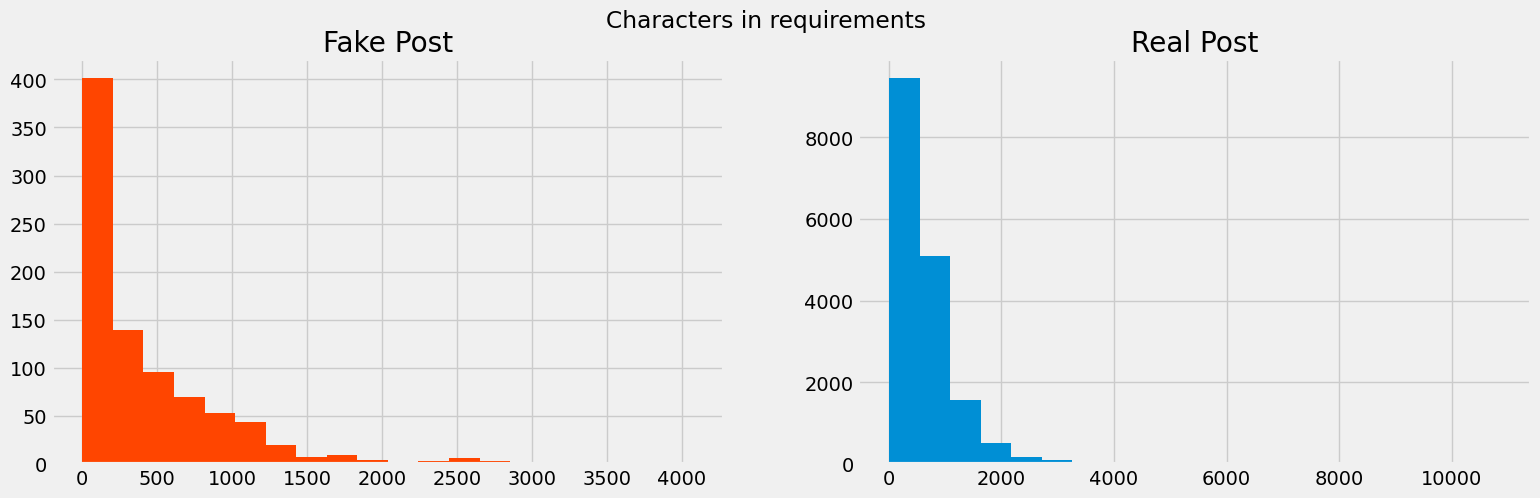

In [9]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['requirements'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['requirements'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in requirements')
plt.show()

The distribution of charaters in requirements of the fake and real post are similar.

#### Benefits

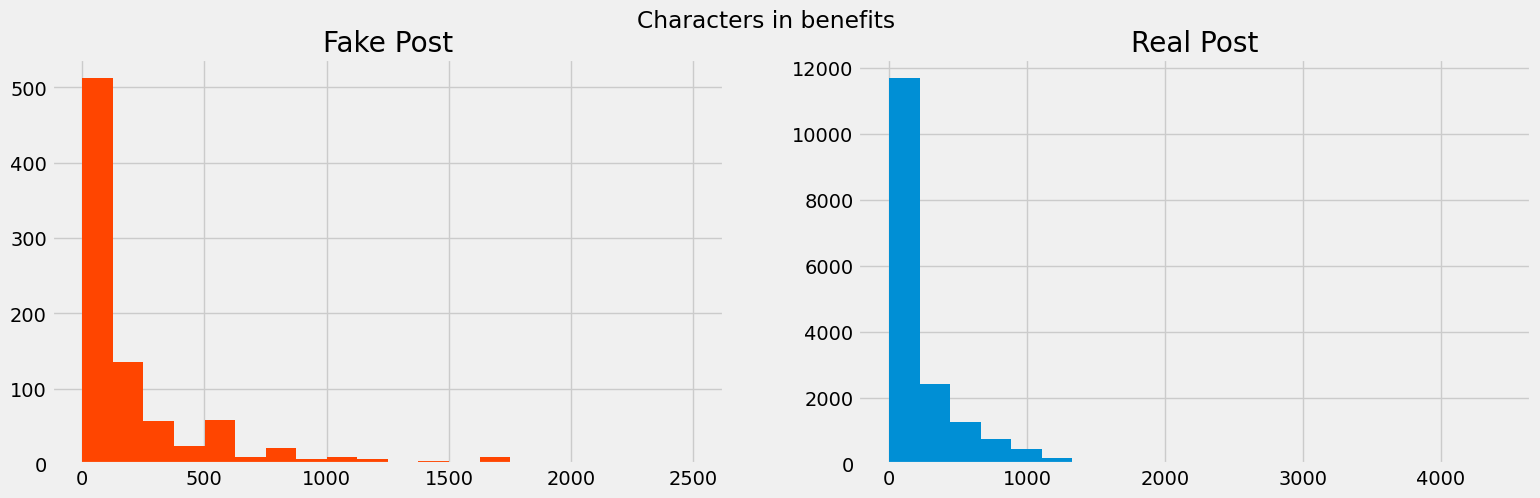

In [10]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['benefits'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['benefits'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in benefits')
plt.show()

The distribution of charaters in requirements of the fake and real post is same around 1500 to 1800.

## Number of words
Let's compare the number of words in the fake post and real post and try to distinguish pattern in the fake and real post based on number of words used in the post.

#### Company Profile

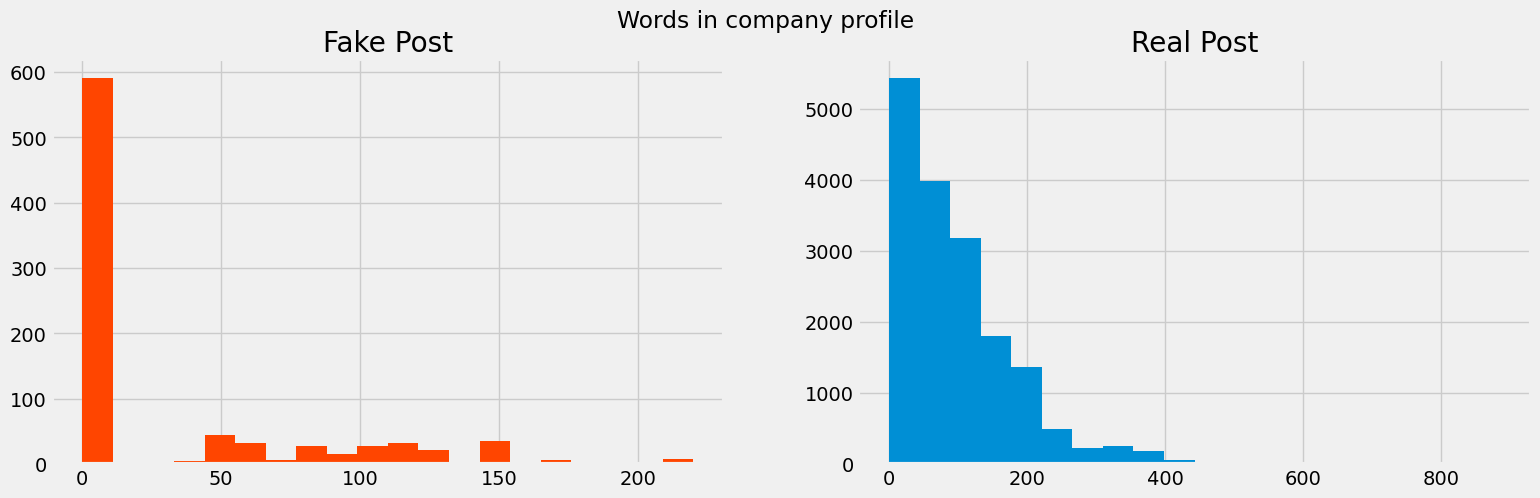

In [11]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['company_profile'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['company_profile'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in company profile')
plt.show()

Pattern of words in company profile is same as character in company profile. **fake post has less words** in the company profile while **real post has more words.**

#### Description

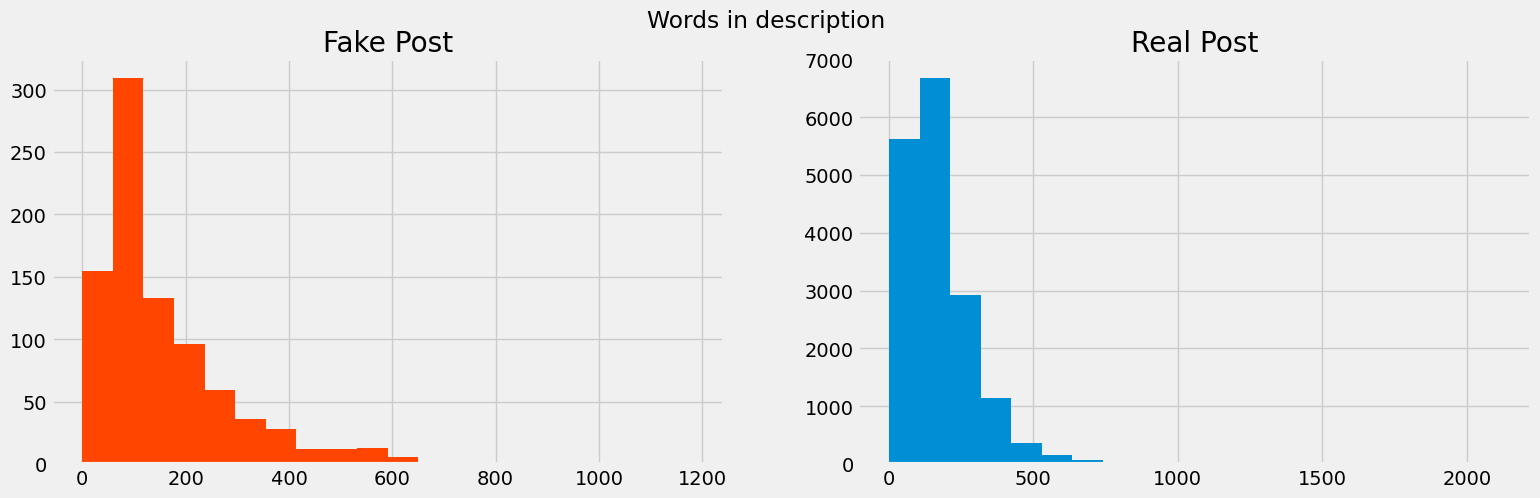

In [12]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['description'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['description'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in description')
plt.show()

Hmm!! Both the post has similar distribution of words in description.

#### Requirements

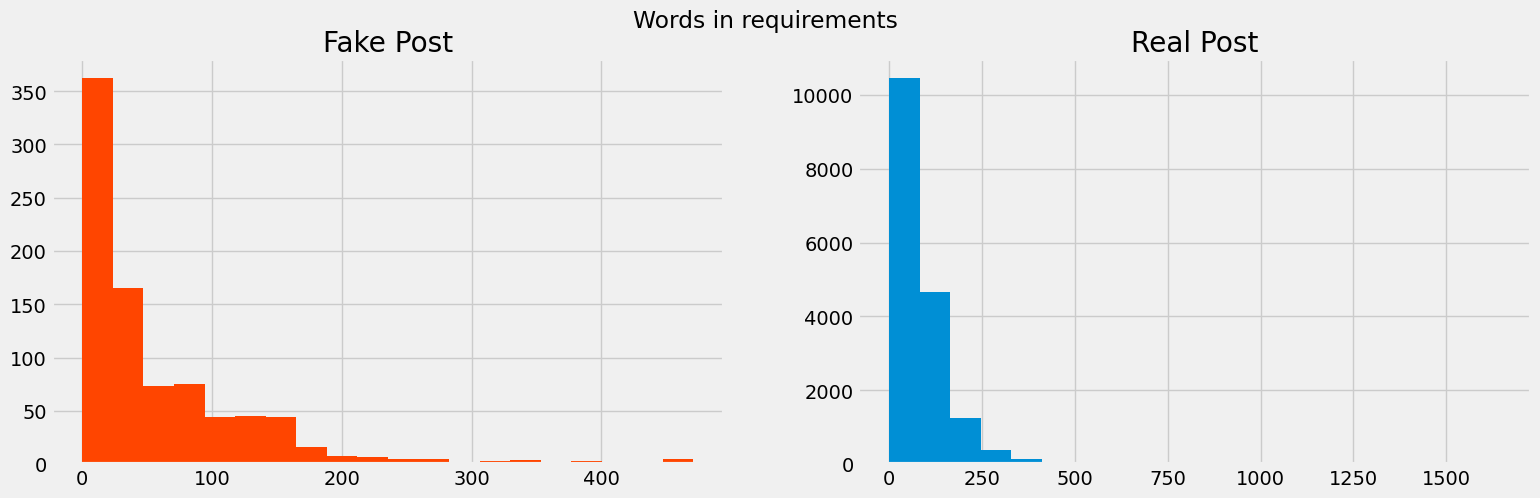

In [13]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['requirements'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['requirements'].str.split().map(lambda x: len(x))
ax2.hist(num,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in requirements')
plt.show()

The distribution of words in requirements of the fake and real post are similar.

#### Benefits

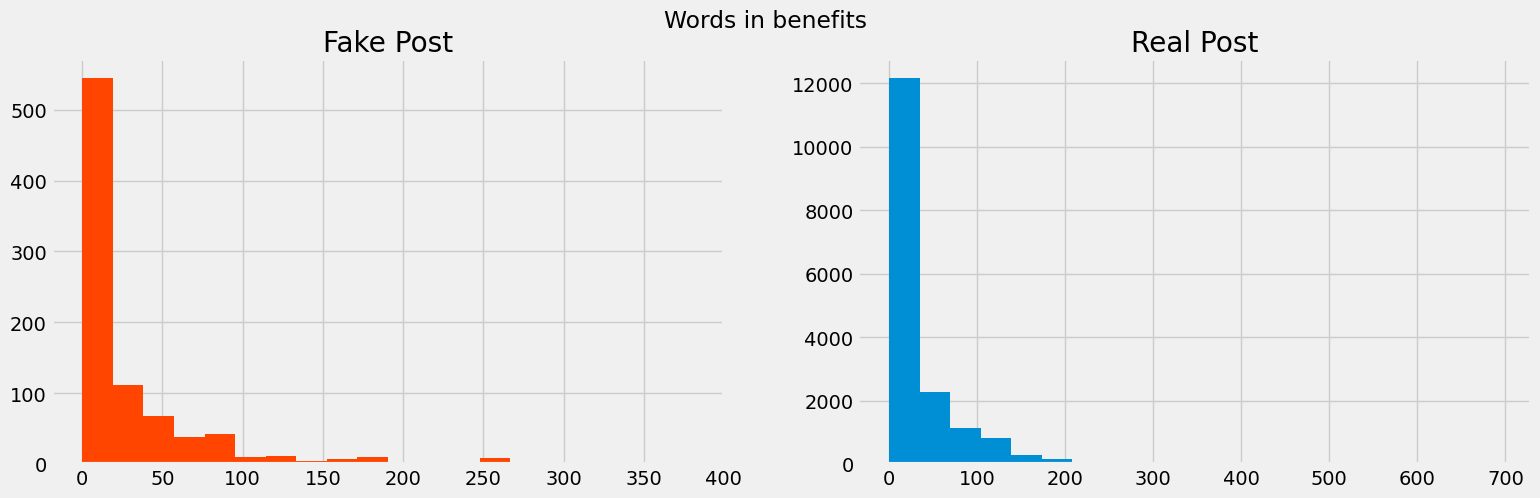

In [14]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['benefits'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['benefits'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in benefits')
plt.show()

The distribution of words in benefits of the fake and real post are also similar.

# Data preprocessing

In [15]:
"""Concate the text data for preprocessing and modeling"""
text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

print(len(text))
print(len(target))

17880
17880


## Ngrams Analysis

Most common unigrams exist in **both classes** are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about target.

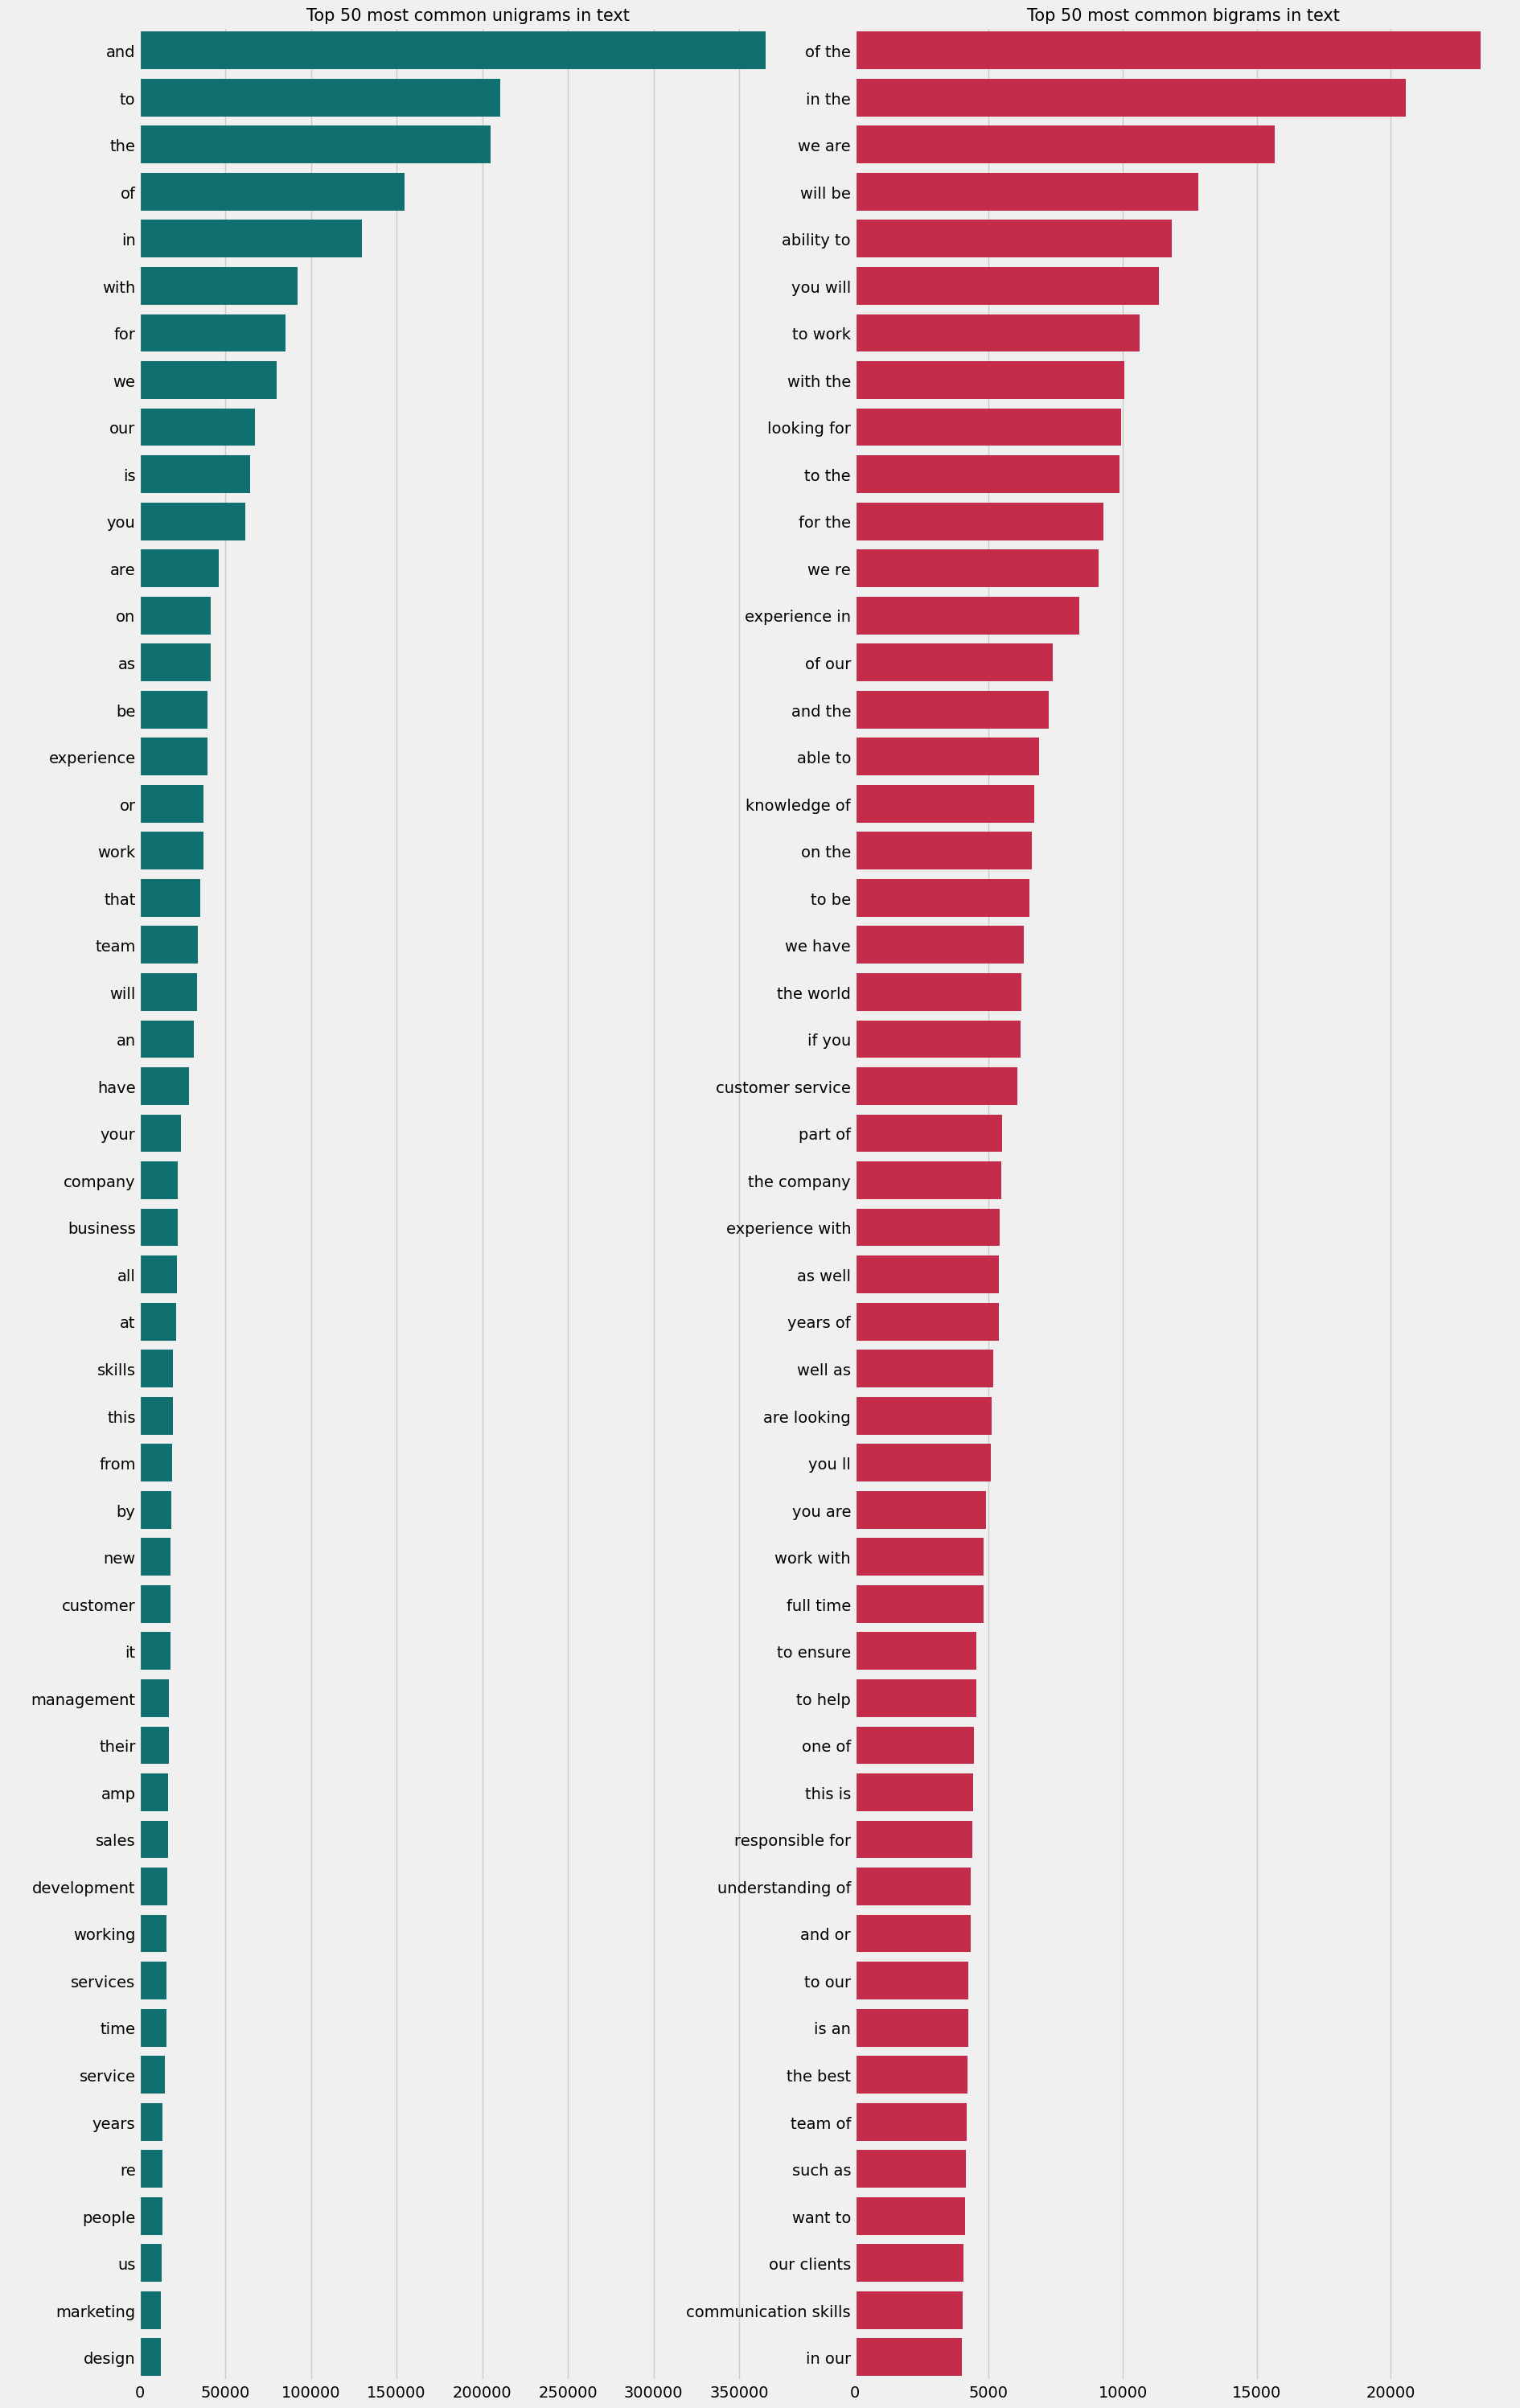

In [16]:
def get_top_tweet_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

top_unigrams=get_top_tweet_unigrams(text)[:50]
x,y=map(list,zip(*top_unigrams))
sns.barplot(x=y,y=x, ax=axes[0], color='teal')


top_bigrams=get_top_tweet_bigrams(text)[:50]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x, ax=axes[1], color='crimson')


axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Top 50 most common unigrams in text', fontsize=15)
axes[1].set_title('Top 50 most common bigrams in text', fontsize=15)

plt.show()

## Text cleaning

In [17]:
%%time
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
text = text.apply(lambda x: clean_text(x))
text.head(3)

CPU times: user 21.4 s, sys: 51.9 ms, total: 21.4 s
Wall time: 21.4 s


0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
dtype: object

## Tokenizer

In [18]:
%%time
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# appling tokenizer5
text = text.apply(lambda x: tokenizer.tokenize(x))
text.head(3)

CPU times: user 3.35 s, sys: 425 ms, total: 3.77 s
Wall time: 3.77 s


0    [marketing, internwere, and, weve, created, a,...
1    [customer, service, cloud, video, seconds, the...
2    [commissioning, machinery, assistant, cmavalor...
dtype: object

In [19]:
%%time
stop_words = stopwords.words('english')
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stop_words]
    return words


text = text.apply(lambda x : remove_stopwords(x))

CPU times: user 14.5 s, sys: 13.9 ms, total: 14.5 s
Wall time: 14.6 s


In [20]:
%%time
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

text = text.apply(lambda x : combine_text(x))
text.head(3)

CPU times: user 251 ms, sys: 60.2 ms, total: 312 ms
Wall time: 311 ms


0    marketing internwere weve created groundbreaki...
1    customer service cloud video seconds worlds cl...
2    commissioning machinery assistant cmavalor ser...
dtype: object

# Baseline Model

In [21]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_buf = []   
cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(text, target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = text[train_ix], text[test_ix]
    train_y, test_y = target[train_ix], target[test_ix]

    # Appling Count Vectorizer
    count_vectorizer = CountVectorizer()
    train_X_vec = count_vectorizer.fit_transform(train_X)
    test_X_vec = count_vectorizer.transform(test_X)    
    
    lr = LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
    lr.fit(train_X_vec, train_y)
    preds = lr.predict(test_X_vec)
    
    auc = roc_auc_score(test_y, preds)
    print('{} AUC: {}'.format(cnt, auc))
    auc_buf.append(auc)
    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('AUC std score = {:.6f}'.format(np.std(auc_buf)))

Fold 1
0 AUC: 0.8486824783980131
Fold 2
1 AUC: 0.8517195809885532
Fold 3
2 AUC: 0.8342316113459901
Fold 4
3 AUC: 0.8720977240415205
Fold 5
4 AUC: 0.8611871313020738
AUC mean score = 0.853584
AUC std score = 0.012670


It's seem simple Logistic Regression model perform well. **AUC mean score of 0.85** demonstrating the good fitting of chosen model. Let's apply Glove for vectorization with deep learning.

# GloVe ¶
Here we will use GloVe pretrained corpus model to represent our words.It is available in 3 varieties :50D ,100D and 200 Dimentional.We will try 200 D here.

In [22]:
# spliting tthe data for glove
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=0.2, random_state=4, stratify=target)

In [23]:
"""Load the Glove vectors in a dictionay"""
embeddings_index={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embeddings_index[word]=vectors
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [24]:
""" Function Creates a normalized vector for the whole sentence"""
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(200)
    return v / np.sqrt((v ** 2).sum())

In [25]:
# create glove features
xtrain_glove = np.array([sent2vec(x) for x in tqdm(X_train)])
xtest_glove = np.array([sent2vec(x) for x in tqdm(X_test)])

100%|██████████| 3576/3576 [00:16<00:00, 210.99it/s]


# Deep Learning 
## Sequential Neural Net 

In [26]:
"""scale the data before any neural net"""
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xtest_glove_scl = scl.transform(xtest_glove)

In [27]:
"""create a simple 2 layer sequential neural net"""
model = Sequential()

model.add(Dense(200, input_dim=200, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model.fit(xtrain_glove_scl, y=y_train, batch_size=64, 
          epochs=10, verbose=1, 
          validation_data=(xtest_glove_scl, y_test))

Train on 14304 samples, validate on 3576 samples
Epoch 1/10
14304/14304 [==============================] - 2s 169us/step - loss: 0.3942 - accuracy: 0.8428 - val_loss: 0.1358 - val_accuracy: 0.9639
Epoch 2/10
14304/14304 [==============================] - 1s 83us/step - loss: 0.1489 - accuracy: 0.9566 - val_loss: 0.1103 - val_accuracy: 0.9698
Epoch 3/10
14304/14304 [==============================] - 1s 86us/step - loss: 0.1154 - accuracy: 0.9635 - val_loss: 0.0996 - val_accuracy: 0.9729
Epoch 4/10
14304/14304 [==============================] - 1s 84us/step - loss: 0.1025 - accuracy: 0.9670 - val_loss: 0.0948 - val_accuracy: 0.9757
Epoch 5/10
14304/14304 [==============================] - 1s 85us/step - loss: 0.0877 - accuracy: 0.9710 - val_loss: 0.0971 - val_accuracy: 0.9754
Epoch 6/10
14304/14304 [==============================] - 1s 85us/step - loss: 0.0787 - accuracy: 0.9732 - val_loss: 0.0940 - val_accuracy: 0.9771
Epoch 7/10
14304/14304 [==============================] - 1s 88us/st

In [29]:
predictions = model.predict(xtest_glove_scl)
predictions = np.round(predictions).astype(int)
print('2 layer sequential neural net on GloVe Feature')
print ("AUC score :", np.round(roc_auc_score(y_test, predictions),5))

2 layer sequential neural net on GloVe Feature
AUC score : 0.81253


**It can safely be said that LR ,in general, is better at discriminating between positives and negatives than LR. Also LR(~ 84%) auc score (which is the area under the roc curve) is greater than equential neural net(~ 74%).We can improve the result by appling diffrent approachs.**

# Simple Bert Implementation

In [30]:
new_text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

In [31]:
%%time
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
new_text = new_text.apply(lambda x: clean_text(x))
new_text.head(3)

CPU times: user 21.5 s, sys: 159 ms, total: 21.7 s
Wall time: 21.7 s


0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
dtype: object

In [32]:
# Trying First 2000 sample
batch_1 = new_text[:2000]
target_1 = target[:2000]
target_1.value_counts()

0    1948
1      52
Name: fraudulent, dtype: int64

In [33]:
# importing the tools 
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [34]:
# DistilBERT
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [35]:
%%time
# Tokenization
tokenized = batch_1.apply((lambda x: tokenizer.encode(x, max_length = 60, add_special_tokens=True)))
tokenized.shape

CPU times: user 45 s, sys: 58.2 ms, total: 45 s
Wall time: 45 s


(2000,)

In [36]:
# Padding ==> convert 1D array to 2D array
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(2000, 60)

In [37]:
# Masking ==>  ignore (mask) the padding we've added
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 60)

In [38]:
# Deep Learning
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

last_hidden_states[0].shape

torch.Size([2000, 60, 768])

In [39]:
features = last_hidden_states[0][:,0,:].numpy()
labels = target_1

### Model 

In [40]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [41]:
# train default para
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
predictions = lr_clf.predict(test_features)
predictions = np.round(predictions).astype(int)
print ("AUC score :", np.round(roc_auc_score(test_labels, predictions),5))

AUC score : 0.77273


The above AUC score is based on the only 2000 sample. we can improve our score by using full dataset and train the bert model on deep learing lebraries. 


## References
1. https://www.kaggle.com/vikassingh1996/different-approaches-to-nlp-problems
2. https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
3. http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

## <font color="red">Give me your feedback and if you find my kernel helpful please UPVOTE will be appreciated.</font>